In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas

import sys
import pprint
import argparse
import datetime
import random
import copy

from model import Basic
from ql_mpcm import QL_MPCM
from mpcm import MPCM
from utils import *
from dataset import read_data, build_dict, load_glove, preprocess

from time import gmtime, strftime
from matplotlib.table import Table

In [3]:
flags = {}
flags['train_epoch'] = 100
flags['test_epoch'] = 1
flags['batch_size'] = 32
flags['dim_perspective'] = 20
flags['dim_embed_word'] = 300
flags['dim_rnn_cell'] = 100
flags['dim_hidden'] = 100
flags['num_paraphrase'] = 1
flags['rnn_layer'] = 1
flags['context_maxlen'] = 200
flags['validation_cnt'] = 100
flags['rnn_dropout'] = 0.5
flags['hidden_dropout'] = 0.5
flags['embed_dropout'] = 0.8
flags['learning_rate'] = 0.00162
flags['max_grad_norm'] = 5.0
flags['embed_trainable'] = False
flags['test'] = False
flags['debug'] = False
flags['save'] = False
flags['sample_params'] = False
flags['model'] = 'm'
flags['train_path'] = './data/train-v1.1.json'
flags['dev_path'] = './data/dev-v1.1.json'
flags['pred_path'] = './result/dev-v1.1-pred.json'
flags['glove_path'] = '~/common/glove/glove.840B.'+ str(flags['dim_embed_word']) +'d.txt'
flags['checkpoint_dir'] = './result/ckpt'

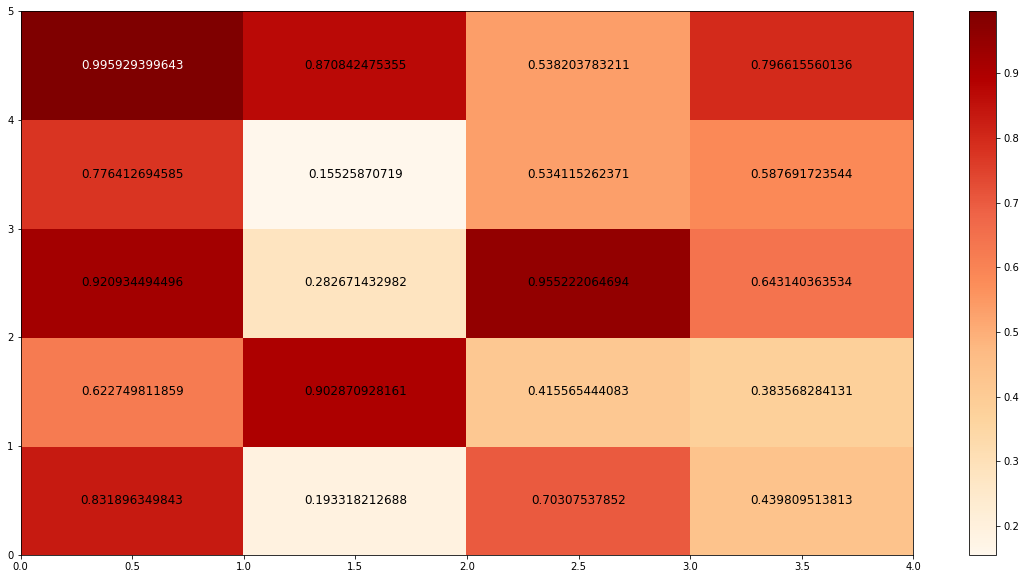

In [11]:
def checkerboard_table(data, text=None):
    data = np.array([i for i in reversed(data)])
    max_idx = np.argmax(data.flatten())
    # print(max_idx)
    heatmap = plt.pcolor(data, cmap='OrRd')
    if text is None:
        text = data
    else:
        text = np.array([i for i in reversed(text)])
    # print(data)

    for y in range(data.shape[0]):
        for x in range(data.shape[1]):
            if x + y * data.shape[1] == max_idx:
                color = 'white'
            else:
                color = 'black'
            plt.text(x + 0.5, y + 0.5, '%s' % text[y, x],
                     horizontalalignment='center',
                     verticalalignment='center', color=color, fontsize=12)

    plt.colorbar(heatmap)

plt.figure(figsize=(20,10))
data = np.random.rand(5, 4)
checkerboard_table(data)
plt.show()

In [5]:
# Load dataset once
expected_version = '1.1'
train_path = flags['train_path']
dev_path = flags['dev_path']
train_dataset = read_data(train_path, expected_version)
dev_dataset = read_data(dev_path, expected_version)

# Preprocess dataset
saved_params = flags
word2idx, idx2word, c_maxlen, q_maxlen = build_dict(train_dataset, saved_params)
pretrained_glove, word2idx, idx2word = load_glove(word2idx, saved_params)
if saved_params['context_maxlen'] > 0: 
    c_maxlen = saved_params['context_maxlen']

train_dataset = preprocess(train_dataset, word2idx, c_maxlen, q_maxlen)
dev_dataset = preprocess(dev_dataset, word2idx, c_maxlen, q_maxlen)
saved_params['context_maxlen'] = c_maxlen
saved_params['question_maxlen'] = q_maxlen
saved_params['voca_size'] = len(word2idx)
saved_params['dim_output'] = c_maxlen

Top 20 frequent words among 103027
[('of', 130668), ('in', 90564), ('and', 86029), ('to', 70981), ('what', 51635), ('is', 37323), ('was', 36275), ('as', 26334), ('for', 25093), ('by', 21712), ('that', 20885), ('with', 20399), ('on', 19459), ('did', 16969), ('are', 16715), ('from', 16562), ('which', 15477), ('were', 13661), ('who', 12626), ('or', 11336)]
executiveembassy 1
digit cnt 4517
alpha cnt 98643
Dictionary size 103027
[('', 0), ('0', 1), ('00', 2), ('000', 3), ('0000', 4), ('0000222556', 5), ('0001', 6), ('00018', 7), ('0002', 8), ('00028', 9), ('0003', 10), ('00042', 11), ('00043', 12), ('0005', 13), ('00054', 14), ('00071', 15), ('00079', 16), ('000–20', 17), ('001', 18), ('0012', 19)]
Maxlen of C:581, Q:34, A:35
Glove Loading...
could not convert string to float: '.'
could not convert string to float: 'name@domain.com'
could not convert string to float: '.'
could not convert string to float: 'name@domain.com'
could not convert string to float: '.'
could not convert string to 

In [7]:
params = copy.deepcopy(flags)
pprint.PrettyPrinter().pprint(params)

# my_model.reset_graph()
# set model name
params['model'] = 'm_0'

# Make model and run experiment
if 'm' in params['model'] :
    my_model = MPCM(params, initializer=[pretrained_glove, word2idx])
elif 'q' in params['model']:
    my_model = QL_MPCM(params, initializer=[pretrained_glove, word2idx])
elif 'b' in params['model']:
    my_model = Basic(params, initializer=[pretrained_glove, word2idx])
else:
    assert False, "Check your version %s" % params['model']

my_model.load(params['checkpoint_dir'])

{'batch_size': 32,
 'checkpoint_dir': './result/ckpt',
 'context_maxlen': 200,
 'debug': False,
 'dev_path': './data/dev-v1.1.json',
 'dim_embed_word': 300,
 'dim_hidden': 100,
 'dim_output': 200,
 'dim_perspective': 20,
 'dim_rnn_cell': 100,
 'embed_dropout': 0.8,
 'embed_trainable': False,
 'glove_path': '~/common/glove/glove.840B.300d.txt',
 'hidden_dropout': 0.5,
 'learning_rate': 0.00162,
 'max_grad_norm': 5.0,
 'model': 'm',
 'num_paraphrase': 1,
 'pred_path': './result/dev-v1.1-pred.json',
 'question_maxlen': 34,
 'rnn_dropout': 0.5,
 'rnn_layer': 1,
 'sample_params': False,
 'save': False,
 'test': False,
 'test_epoch': 1,
 'train_epoch': 100,
 'train_path': './data/train-v1.1.json',
 'validation_cnt': 100,
 'voca_size': 64652}
### Building MPCM model ###
# Filter_layer Tensor("Filter_Layer/Mul:0", shape=(?, 200, 300), dtype=float32, device=/device:GPU:0)
# Representation_layer Tensor("Representation_Layer/Context/Bi-RNN/concat:0", shape=(?, 200, 200), dtype=float32, device=/de

[context] len=77
historian francis aidan gasquet wrote about great pestilence in 1893 and suggested that it would appear to be some form of ordinary eastern or bubonic plague he was able to adopt epidemiology of bubonic plague for black death for second edition in 1908 implicating rats and fleas in process and his interpretation was widely accepted for other ancient and medieval epidemics such as justinian plague that was prevalent in eastern roman empire from 541 to 700 ce

[question] len=7
what did gasquets book blame plague on

[ground truth]
['rats and fleas', 'rats and fleas', 'rats and fleas']

[prediction]
black death



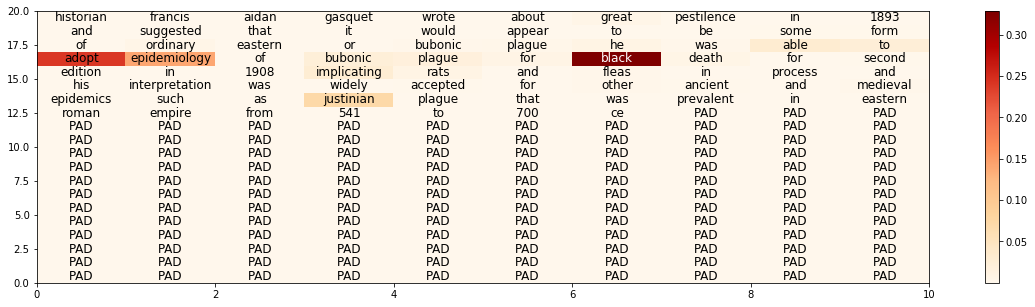

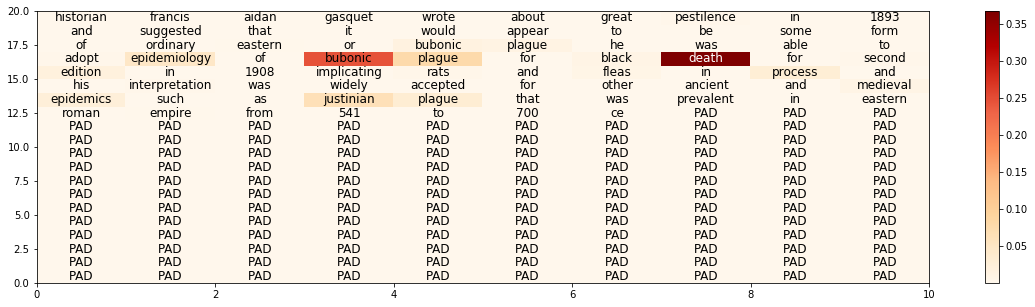

AssertionError: 

In [28]:
model = my_model
sess = model.session
batch_size = params['batch_size']
mini_batch = []
ground_truths = []
context_raws = []
question_raws = []

total_loss = total_f1 = total_em = total_cnt = 0
dataset = dev_dataset

for dataset_idx, dataset_item in enumerate(dataset):
    context = dataset_item['c']
    context_raw = dataset_item['c_raw']
    context_len = dataset_item['c_len']
    for qa in dataset_item['qa']:
        question = qa['q']
        question_len = qa['q_len']
        question_raw = qa['q_raw']
        answer = qa['a']
        answer_start = qa['a_start']
        answer_end = qa['a_end']

        ground_truths = [answer]
        context_raws = [context_raw]
        question_raws = [question_raw]

        batch_context = [context]
        batch_context_len = [context_len]
        batch_question = [question]
        batch_question_len = [question_len]
        batch_answer_start = [answer_start]
        batch_answer_end = [answer_end]
        
        if 'historian francis aidan gasquet wrote about great' not in str(' ').join(context_raw):
            continue
        
        if 'what did gasquets book blame plague on' not in str(' ').join(question_raw):
            continue
        
        if False:
            paraphrase = 'what is mortality rate of new new new'
            question_raws = [paraphrase.split(' ')]
            batch_question_len = [len(paraphrase.split(' '))]
            batch_question = [[word2idx[w] for w in paraphrase.split(' ')]]
            while len(batch_question[0]) != model.question_maxlen:
                batch_question[0] = np.append(batch_question[0], word2idx['PAD'])
            
        feed_dict = {model.context: batch_context,
            model.context_len: batch_context_len,
            model.question: batch_question,
            model.question_len: batch_question_len,
            model.answer_start: batch_answer_start,
            model.answer_end: batch_answer_end,
            model.rnn_dropout: 1.0,
            model.hidden_dropout: 1.0,
            model.embed_dropout: 1.0}

        loss, start_logits, end_logits = sess.run(
                [model.loss, model.start_logits, model.end_logits], 
                feed_dict=feed_dict)
        start_idx = [np.argmax(sl[:cl], 0)
                for sl, cl in zip(start_logits, batch_context_len)]
        end_idx = [np.argmax(el[si:cl], 0) + si
                for el, si, cl in zip(end_logits, start_idx, batch_context_len)]
        predictions = []
        
        for c, s_idx, e_idx in zip(context_raws, start_idx, end_idx):
            predictions.append(' '.join([w for w in c[s_idx: e_idx+1]]))
        
        em = f1 = 0 
        for prediction, ground_truth, ctr, qur in zip(
                predictions, ground_truths, context_raws, question_raws):
            
            single_em = metric_max_over_ground_truths(
                    exact_match_score, prediction, ground_truth)
            single_f1 = metric_max_over_ground_truths(
                    f1_score, prediction, ground_truth)
            
            test_correct = True if single_f1 > 0 else False
            test_c = str(' '.join(ctr))
            print('[context] len=%d\n%s\n' % (context_len, test_c))
            test_q = str(' '.join(qur))
            print('[question] len=%d\n%s\n' % (question_len, test_q))
            test_gt = str(ground_truth)
            print('[ground truth]\n%s\n' % test_gt)
            test_pr = str(prediction)
            print('[prediction]\n%s\n' % test_pr)
            
            while len(ctr) != len(start_logits[0]):
                ctr = np.append(ctr, 'PAD')
            
            def softmax(x):
                e_x = np.exp(x - np.max(x))
                return e_x / e_x.sum(axis=0)
            
            plt.figure(figsize=(20,5))
            data = np.reshape(softmax(start_logits[0]), (20, 10))
            text = np.reshape(ctr, (20, 10))
            checkerboard_table(data, text)
            plt.show()
            
            plt.figure(figsize=(20,5))
            data = np.reshape(softmax(end_logits[0]), (20, 10))
            checkerboard_table(data, text)
            plt.show()
            
            assert False

            em += single_em
            f1 += single_f1

        _progress = "[loss: %.3f, f1: %.3f, em: %.3f]\n\n" % (loss, f1 /
                len(predictions), em / len(predictions)) 
        sys.stdout.write(_progress)
        sys.stdout.flush()